In [1]:
import numpy as np # type: ignore
import pandas as pd # type: ignore
import matplotlib.pyplot as plt # type: ignore
import yfinance as yf # type: ignore

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

# Load financial data

In [2]:
data = yf.download('AAPL')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
data.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
1980-12-12,0.098726,0.099155,0.098726,0.098726,469033600
1980-12-15,0.093575,0.094005,0.093575,0.094005,175884800
1980-12-16,0.086707,0.087136,0.086707,0.087136,105728000
1980-12-17,0.088853,0.089282,0.088853,0.088853,86441600
1980-12-18,0.091429,0.091858,0.091429,0.091429,73449600


In [4]:
X = data.to_numpy()
X.shape

(11143, 5)

In [5]:
def create_sequence(data: np.ndarray, seq_len: int = 8, target_sequence: bool = False) -> tuple[np.ndarray, np.ndarray]:
    X = []
    y = []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        if target_sequence:
            y.append(data[(i+1):(i+1+seq_len)])
        else:
            y.append(data[i+seq_len])
    return np.array(X), np.array(y)

# Split and scale

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()

X_train, X_test = train_test_split(X, test_size=0.2)

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

print(f'Train: {X_train.shape}, Test: {X_test.shape}')

Train: (8914, 5), Test: (2229, 5)


# Create sequences

In [7]:
X_train, y_train = create_sequence(X_train)
X_test, y_test = create_sequence(X_test)

print(f'X, y_train: {X_train.shape} {y_train.shape}')
print(f'X, y_test: {X_test.shape} {y_test.shape}')

X, y_train: (8906, 8, 5) (8906, 5)
X, y_test: (2221, 8, 5) (2221, 5)


In [9]:
y_train, y_test = y_train.reshape(-1, 1, 5), y_test.reshape(-1, 1, 5)
print(f'y_train, y_test: {y_train.shape}, {y_test.shape}')

y_train, y_test: (8906, 1, 5), (2221, 1, 5)


# Custom dataset

In [10]:
class StockDataset(Dataset):

    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        """
        Returns the number of samples in the dataset.
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Retrieves the data and label at the given index.
        
        Args:
            idx (int): The index of the sample to retrieve.
        
        Returns:
            tuple: (data, label)
        """
        sample = self.data[idx]
        target = self.targets[idx]
        return sample, target

# Data preparation

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

X_train, X_test, y_train, y_test = torch.Tensor(X_train), torch.Tensor(X_test), torch.Tensor(y_train), torch.Tensor(y_test)
X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

In [12]:
batch_size = 32

dataset_train = StockDataset(X_train, y_train)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_test = StockDataset(X_test, y_test)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

In [13]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim, num_heads, num_layers=6, dim_ff=2048, dropout=0.1):
        super(TransformerModel, self).__init__()
        
        self.transformer = nn.Transformer(
            d_model=input_dim,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=dim_ff, 
            dropout=dropout,
            batch_first=True
        )
        
        self.fc_out = nn.Linear(input_dim, output_dim)

    def forward(self, src, tgt):
        output = self.transformer(src, tgt)
        #output = output[:, -1, :] # For one output instead of sequence
        output = self.fc_out(output)
        return output

In [15]:
n_features = 5

model = TransformerModel(input_dim=n_features, output_dim=n_features, num_heads=5)
model = model.to(device)

d:\Grgo\Programs\Python_venv\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


In [16]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)

model.train()

for epoch in range(100):

    epoch_loss = 0

    for data, target in dataloader_train:
        optimizer.zero_grad()
        output = model(data, target)
        loss = criterion(output, target)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    print(f"Epoch: {epoch+1}, Loss: {epoch_loss / len(dataloader_train)}")

Epoch: 1, Loss: 1.0171597716415228
Epoch: 2, Loss: 0.7531920336053363
Epoch: 3, Loss: 0.5367571165164312
Epoch: 4, Loss: 0.5038068590412003
Epoch: 5, Loss: 0.9649805364642946
Epoch: 6, Loss: 0.7012630620417202
Epoch: 7, Loss: 0.9721706673556332
Epoch: 8, Loss: 0.5666332182384306
Epoch: 9, Loss: 0.4762325843388889
Epoch: 10, Loss: 0.4672876811422755
Epoch: 11, Loss: 0.4888899586694215
Epoch: 12, Loss: 0.4385145832934687
Epoch: 13, Loss: 0.4201022057550355
Epoch: 14, Loss: 0.43618637358095486
Epoch: 15, Loss: 0.47444915747450245
Epoch: 16, Loss: 0.40659087023106955
Epoch: 17, Loss: 0.4341978707140492
Epoch: 18, Loss: 0.4276033150679749
Epoch: 19, Loss: 0.43342889241847515
Epoch: 20, Loss: 0.4057078982392947
Epoch: 21, Loss: 0.42949748971235796
Epoch: 22, Loss: 0.451184666925861
Epoch: 23, Loss: 0.4696155345888548
Epoch: 24, Loss: 0.4521390513707233
Epoch: 25, Loss: 0.4134238038385641
Epoch: 26, Loss: 0.44082124990588023
Epoch: 27, Loss: 0.43836976582431453
Epoch: 28, Loss: 0.484989698001

KeyboardInterrupt: 

In [17]:
model.eval()

with torch.no_grad():

    val_output = model(X_test, y_test)
    val_loss = criterion(val_output, y_test)
    print(f"Validation Loss: {val_loss.item()}")

Validation Loss: 0.44429531693458557


In [18]:
true_unscaled = scaler_X.inverse_transform(y_test.reshape(-1, 5).cpu())[:20]
predicted_unscaled = scaler_X.inverse_transform(val_output.reshape(-1, 5).cpu())[:20]
print(f'Shapes: {true_unscaled.shape}, {predicted_unscaled.shape}')

Shapes: (20, 5), (20, 5)


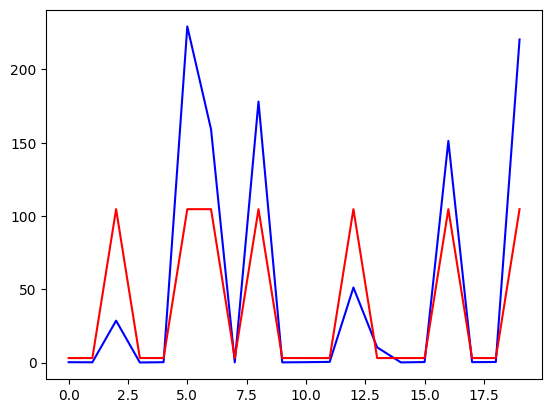

In [19]:
x = [i for i in range(len(true_unscaled))]
plt.plot(x, true_unscaled[:, 0], color='blue')
plt.plot(x,predicted_unscaled[:, 0], color='red')
plt.show()